<h1 align=center><font size = 5>Clustering Zip Codes in West Virginia for Retirement</font></h1>


## Introduction

This notebook will be used to complete the coding needed for the Applied Data Science Capstone project using Foursquare location data.


Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# Install the geocoder to find coordinates for each zip code.
!pip install geocoder
import geocoder # import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

!pip install folium
import folium # map rendering library

!pip install lxml html5lib beautifulsoup4

print('Libraries imported.')

     |████████████████████████████████| 102kB 2.5MB/s ta 0:00:011
     |████████████████████████████████| 5.5MB 5.7MB/s eta 0:00:01     |██████████████▊                 | 2.5MB 5.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 36.2MB/s eta 0:00:01
Libraries imported.


## 1. Download and Explore Dataset


First we need to obtain the Zip Codes for West Virginia, which  can be found at the zipcode.com website, and also give the name of the Common Cities and County for each zip. This will be useful in merging data as we go on. The zip codes that correspond to P.O. Boxes only will need to be deleted, as the do no represent potential living areas.
Pandas' read_html function will traverse through the webpage and find tabular data, and convert the table into a dataframe. 

In [4]:
df_WVzip=pd.read_csv("WVzipdata.csv")
df_WVzip.head()

,zip,Type,city,county,pop
0,24701,Standard,Bluefield,Mercer,19667
1,24712,Standard,Athens,Mercer,2189
2,24714,Standard,Beeson,Mercer,252
3,24715,Standard,Bramwell,Mercer,439
4,24716,P.O. Box,Bud,Wyoming,417


Cleaning and reformating the Zip Code dataframe

In [5]:
# Removing zip codes that do not represent Standard land areas".
df_WVzip = df_WVzip[df_WVzip.Type != "P.O. Box"]

#reset the index
df_WVzip = df_WVzip.reset_index(drop=True)

#Change column name from 'zip' to 'zipcode' to avoid problems with Folium mapping later
df_WVzip = df_WVzip.rename(columns={'zip': 'zipcode'})

#Check format
df_WVzip.head()    

,zipcode,Type,city,county,pop
0,24701,Standard,Bluefield,Mercer,19667
1,24712,Standard,Athens,Mercer,2189
2,24714,Standard,Beeson,Mercer,252
3,24715,Standard,Bramwell,Mercer,439
4,24724,Standard,Freeman,Mercer,130


The next section will add the location coordinates for each zip code.

In [7]:
# initialize your variable to None

latitude = []
longitude = []

#for i in df_WVzip["ZIP Code"].count:
for index, row in df_WVzip.iterrows(): 
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{},{}, WV'.format(df_WVzip.iloc[index, 0], df_WVzip.iloc[index, 2]))
      lat_lng_coords = g.latlng

    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])
    
df_WVzip["latitude"] = latitude
df_WVzip["longitude"] = longitude

df_WVzip.to_csv('wvzip.csv')

df_WVzip.head()

Let's get a sense of the size of the problem: how many counties and zip codes are there?

In [14]:
# Read already downloaded csv
df_WVzip = pd.read_csv('wvzip.csv', index_col=0)
df_WVzip.head()

,zipcode,Type,city,county,pop,latitude,longitude
0,24701,Standard,Bluefield,Mercer,19667,37.266735,-81.225225
1,24712,Standard,Athens,Mercer,2189,37.421470,-81.009585
2,24714,Standard,Beeson,Mercer,252,37.469826,-81.189609
3,24715,Standard,Bramwell,Mercer,439,37.322730,-81.324500
4,24724,Standard,Freeman,Mercer,130,37.328805,-81.304115


In [3]:
print('The dataframe has {} counties and {} zip codes.'.format(
        len(df_WVzip['county'].unique()),
        df_WVzip.shape[0]
    )
)

The dataframe has 55 counties and 580 zip codes.


#### Create a map of West Virginia with ZIP codes superimposed on top.


Let's get the geographical coordinates of West Virginia.


In [4]:
lat_lng_coords = None
    # loop until you get the coordinates
while(lat_lng_coords is None):
    g = geocoder.arcgis('WV')
    lat_lng_coords = g.latlng

Latitude=lat_lng_coords[0]
Longitude=lat_lng_coords[1]

print('The geograpical coordinate of West Virginia are {}, {}.'.format(Latitude, Longitude))

The geograpical coordinate of West Virginia are 38.64241493700007, -80.61361664099996.


In [7]:
# create map of West Virginia using latitude and longitude values
map_wv = folium.Map(location=[Latitude, Longitude], zoom_start=10)

# add markers to map
for lat, lng, zipcode, county in zip(df_WVzip['latitude'], df_WVzip['longitude'], df_WVzip['zipcode'], df_WVzip['county']):
    label = '{}, {}'.format(zipcode, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wv)  

sw = df_WVzip[['latitude', 'longitude']].min().values.tolist()
ne = df_WVzip[['latitude', 'longitude']].max().values.tolist()

map_wv.fit_bounds([sw, ne]) 

# where m is my map object. And 5 is the time (seconds) to render the map
import io
from PIL import Image

img_data = map_wv._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('ZIPmap.png')

map_wv

TypeError: _to_png() takes 1 positional argument but 3 were given

In [ ]:
#Possible code to create a png file that can be imported to Word.

import io
from PIL import Image

img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')

## 2. Find venues by zip code for West Virginia


#### Now we need to download the Foursquare data using the Foursquare API.

First make sure the proper Foursquare credentials and version are referenced.

In [2]:
CLIENT_ID = '3JSR50CDUPBEZDMP5K0U3J3SEJWPWBOKASYCSNAPOLJMDEKT' # your Foursquare ID
CLIENT_SECRET = '1PL5KTKOSCUPLO4ZYT3EOI4Q3IVIQSFLGKQBJJ1LQMZEA1KX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
#LIMIT = 100 # A default Foursquare API limit value

The first API ask is for: 
- Supermarkets (52f2ab2ebcbc57f1066b8b46)
- Restaurants, or food (4d4b7105d754a06374d81259)
- Medical centers (4bf58dd8d48988d104941735)
- Spiritual centers (4bf58dd8d48988d131941735)
- Arts and entertainment venues (4d4b7104d754a06370d81259)
- Outdoors and recreations(4d4b7105d754a06377d81259)
- Real estate offices (5032885091d4c4b30a586d66) 
- Bus stops(52f2ab2ebcbc57f1066b8b4f)

<p>The radius will be limited to 10000 meters, which is roughly 6 1/4 miles.  This should represent a reasonable short drive of no more than 15 minutes.

<p>Basic format of the ask:
https://api.foursquare.com/v2/venues/search?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=LATITUDE,LONGITUDE&v=VERSION&query=QUERY&radius=RADIUS&limit=LIMIT
    
<p>Note that looping through all 580 zip code for venues from 8 categories would give a total of 4640 venue/search requests.  With a limit of 5000 requests per hour, this code can be run only once per hour.


In [3]:
category_list = {
     'category': ['Supermarkets', 'Food', 'Medical Centers', 'Spritual Centers', 'Arts and Ent',
                  'Outdoors', 'Real Estate', 'Bus Stops'],
     'cat_code': ['52f2ab2ebcbc57f1066b8b46', '4d4b7105d754a06374d81259', '4bf58dd8d48988d104941735',
              '4bf58dd8d48988d131941735', '4d4b7104d754a06370d81259', '4d4b7105d754a06377d81259',
              '5032885091d4c4b30a586d66','52f2ab2ebcbc57f1066b8b4f'],
 }
category_df = pd.DataFrame(category_list)

In [4]:
def get_venues_count(lat, long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                long,
                radius,
                categoryId)

    results = requests.get(explore_url).json()["response"]['totalResults']
    return results

In [7]:
#Create new dataframe to store venues data
df_wvzip_venues = df_WVzip.copy()
for c in category_list:
    df_wvzip_venues[c[0]] = 0

In [5]:
#Read already stored CSV after creating df above the first time through.
df_wvzip_venues = pd.read_csv('wvzip_final.csv', index_col=0)
df_wvzip_venues.head()

,zipcode,Type,city,county,pop,latitude,longitude,c,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
0,24701,Standard,Bluefield,Mercer,19667,37.266735,-81.225225,0,3.0,35.0,34.0,13.0,3.0,0.0,4.0,0.0,1514,2744
1,24712,Standard,Athens,Mercer,2189,37.421470,-81.009585,0,1.0,33.0,14.0,8.0,2.0,0.0,0.0,0.0,7400,11162
2,24714,Standard,Beeson,Mercer,252,37.469826,-81.189609,0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,13712,61617
3,24715,Standard,Bramwell,Mercer,439,37.322730,-81.324500,0,1.0,10.0,1.0,3.0,2.0,0.0,0.0,0.0,10835,19644
4,24724,Standard,Freeman,Mercer,130,37.328805,-81.304115,0,1.0,15.0,5.0,8.0,4.0,0.0,0.0,0.0,10136,17740


In [21]:
#Request number of venues, by category. Almost 5000 calls so don't do often.
# This had to be run multiple times, waiting an hour between iterations to stay within Foursquare limits.

for i, row in df_wvzip_venues.iterrows():
    if i > 19:
        break  #These rows have already been updated, so skip them this time around.
    print(i)
    
    for index, c in category_df.iterrows():

        #print(c[0])
        df_wvzip_venues.loc[i, c[0]] = get_venues_count(
            df_wvzip_venues.latitude.iloc[i], df_wvzip_venues.longitude.iloc[i], radius=10000, categoryId=c[1]
            )


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [20]:
print(i)
print(index)
#df_wvzip_venues.loc[45:50,]
print(requests.get(explore_url).json()["response"])

114
2


NameError: name 'explore_url' is not defined

Create a csv file to save results up to this point.

In [7]:
df_wvzip_venues.to_csv('wvzip_venues.csv')

df_wvzip_venues.head()      

NameError: name 'df_wvzip_venues' is not defined

In [5]:
#Read already stored CSV after creating df above the first time through.
df_wvzip_venues = pd.read_csv('wvzip_venues.csv', index_col=0)
df_wvzip_venues.head()

,zipcode,Type,city,county,pop,latitude,longitude,c,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops
0,24701,Standard,Bluefield,Mercer,19667,37.266735,-81.225225,0,3.0,35.0,34.0,13.0,3.0,0.0,4.0,0.0
1,24712,Standard,Athens,Mercer,2189,37.421470,-81.009585,0,1.0,33.0,14.0,8.0,2.0,0.0,0.0,0.0
2,24714,Standard,Beeson,Mercer,252,37.469826,-81.189609,0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0
3,24715,Standard,Bramwell,Mercer,439,37.322730,-81.324500,0,1.0,10.0,1.0,3.0,2.0,0.0,0.0,0.0
4,24724,Standard,Freeman,Mercer,130,37.328805,-81.304115,0,1.0,15.0,5.0,8.0,4.0,0.0,0.0,0.0


#### Distance to Hospitals and Universities/Colleges
For rarer venues like hospitals and universities, what matters is the distance to get there, not the total number that are within a radius.  This requires a different function to pull the right data using the Foursquare API.

- Hospital (4bf58dd8d48988d196941735)
- University/College (4d4b7105d754a06372d81259)

For Universities and Colleges in particular, we are likely to get many venues for the same institution because of how the categories are arranged in Foursquare. It will include buildings, labs, dorms, stadiums, etc. so we will use the minimum of all these distances to determine how far it is to the institution.


In [26]:
def getVenueDistance(zipcode, latitudes, longitudes, categoryId, radius=100000):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcode, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            categoryId) 
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            v['venue']['name'], 
            v['venue']['location']['distance']) for v in results])

    relevant_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    relevant_venues.columns = ['ZIPCode', 
                  'Venue', 
                  'Venue Distance']
    
    return(relevant_venues)

#### We'll need to apply the above code in two separate loops: one for each category. After each set of venues is created, we will need a .groupby


In [27]:
# Loop for hospital distances
hospital_distance = getVenueDistance(zipcode=df_WVzip['zipcode'],
                                   latitudes=df_WVzip['latitude'],
                                   longitudes=df_WVzip['longitude'],
                                   categoryId = '4bf58dd8d48988d196941735'
                                  )

# Find the minimum distance for each zip code.
hosp_result = hospital_distance.groupby('ZIPCode').agg({'Venue Distance': ['min']}) 

hosp_result.head()

,Venue Distance
,min
ZIPCode,
24701,1514
24712,7400
24714,13712
24715,10835
24724,10136


In [28]:
#If each row already has a unique index, then do this:

df_Hmin = hospital_distance.loc[hospital_distance.groupby('ZIPCode')['Venue Distance'].idxmin()]
df_Hmin.reset_index(inplace = True, drop = True)
df_Hmin.head(10)


,ZIPCode,Venue,Venue Distance
0,24701,Bluefield Regional Medical Center,1514
1,24712,MedExpress Urgent Care,7400
2,24714,Princeton Community Hospital,13712
3,24715,Bluefield Regional Medical Center,10835
4,24724,Bluefield Regional Medical Center,10136
5,24726,STAT,20266
6,24731,Princeton Community Hospital,5027
7,24733,Princeton Community Hospital,12752
8,24736,Princeton Community Hospital,13178
9,24740,Kindred at Home,1652


In [17]:
df_Hmin.shape


(580, 3)

In [29]:
df_wvzip_venues[["Hopital"]] = df_Hmin[["Venue Distance"]]
df_wvzip_venues.head()

,zipcode,Type,city,county,pop,latitude,longitude,c,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital
0,24701,Standard,Bluefield,Mercer,19667,37.266735,-81.225225,0,3.0,35.0,34.0,13.0,3.0,0.0,4.0,0.0,1514
1,24712,Standard,Athens,Mercer,2189,37.421470,-81.009585,0,1.0,33.0,14.0,8.0,2.0,0.0,0.0,0.0,7400
2,24714,Standard,Beeson,Mercer,252,37.469826,-81.189609,0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,13712
3,24715,Standard,Bramwell,Mercer,439,37.322730,-81.324500,0,1.0,10.0,1.0,3.0,2.0,0.0,0.0,0.0,10835
4,24724,Standard,Freeman,Mercer,130,37.328805,-81.304115,0,1.0,15.0,5.0,8.0,4.0,0.0,0.0,0.0,10136
5,24726,Standard,Herndon,Wyoming,562,37.500043,-81.335004,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,20266
6,24731,Standard,Kegley,Mercer,246,37.395082,-81.152801,0,1.0,42.0,44.0,8.0,17.0,0.0,4.0,0.0,5027
7,24733,Standard,Lashmeet,Mercer,630,37.443465,-81.215461,0,0.0,5.0,1.0,3.0,0.0,0.0,0.0,0.0,12752
8,24736,Standard,Matoaka,Mercer,493,37.417535,-81.245337,0,0.0,4.0,1.0,4.0,0.0,0.0,0.0,0.0,13178
9,24740,Standard,Princeton,Mercer,30672,37.370480,-81.094850,0,2.0,39.0,47.0,9.0,20.0,0.0,4.0,0.0,1652


In [30]:
# Loop for university distances
univ_distance = getVenueDistance(zipcode=df_WVzip['zipcode'],
                                   latitudes=df_WVzip['latitude'],
                                   longitudes=df_WVzip['longitude'],
                                    categoryId = '4d4b7105d754a06372d81259'
                                  )

# Find the minimum distance for each zip code.
univ_result = hospital_distance.groupby('ZIPCode').agg({'Venue Distance': ['min']}) 
univ_result.head(10)

# Merge these results with the df_wvzip_venues.
#df_wvzip_venues['Univ'] = univ_result

# Fill the zipcodes that don't find a university with a distance larger than the possible results to indicate no easy access.
#df_wvzip_venues['Univ'] = df_wvzip_venues['Univ'].fillna(500000)

,Venue Distance
,min
ZIPCode,
24701,1514
24712,7400
24714,13712
24715,10835
24724,10136
24726,20266
24731,5027
24733,12752


In [32]:
#If each row already has a unique index, then do this:

df_Umin = hospital_distance.loc[univ_distance.groupby('ZIPCode')['Venue Distance'].idxmin()]
df_Umin.reset_index(inplace = True, drop = True)
df_Umin.head()


,ZIPCode,Venue,Venue Distance
0,24701,The Behavioral Health Pavilion of the Virginias,2744
1,24712,Encompass Health Rehabilitation Hospital of Pr...,11162
2,24714,Alliance Xpress Urgent Care,61617
3,24715,Kindred at Home,19644
4,24724,Kindred at Home,17740


In [33]:
df_wvzip_venues[["UnivColl"]] = df_Umin[["Venue Distance"]]
df_wvzip_venues.head()

,zipcode,Type,city,county,pop,latitude,longitude,c,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
0,24701,Standard,Bluefield,Mercer,19667,37.266735,-81.225225,0,3.0,35.0,34.0,13.0,3.0,0.0,4.0,0.0,1514,2744
1,24712,Standard,Athens,Mercer,2189,37.421470,-81.009585,0,1.0,33.0,14.0,8.0,2.0,0.0,0.0,0.0,7400,11162
2,24714,Standard,Beeson,Mercer,252,37.469826,-81.189609,0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,13712,61617
3,24715,Standard,Bramwell,Mercer,439,37.322730,-81.324500,0,1.0,10.0,1.0,3.0,2.0,0.0,0.0,0.0,10835,19644
4,24724,Standard,Freeman,Mercer,130,37.328805,-81.304115,0,1.0,15.0,5.0,8.0,4.0,0.0,0.0,0.0,10136,17740


#### Let's check the size of the resulting dataframe


In [20]:
print(df_wvzip_venues.shape)
df_wvzip_venues.head()

(580, 18)


,zipcode,Type,city,county,pop,latitude,longitude,c,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
0,24701,Standard,Bluefield,Mercer,19667,37.266735,-81.225225,0,3.0,35.0,34.0,13.0,3.0,0.0,4.0,0.0,1514,2744
1,24712,Standard,Athens,Mercer,2189,37.421470,-81.009585,0,1.0,33.0,14.0,8.0,2.0,0.0,0.0,0.0,7400,11162
2,24714,Standard,Beeson,Mercer,252,37.469826,-81.189609,0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,13712,61617
3,24715,Standard,Bramwell,Mercer,439,37.322730,-81.324500,0,1.0,10.0,1.0,3.0,2.0,0.0,0.0,0.0,10835,19644
4,24724,Standard,Freeman,Mercer,130,37.328805,-81.304115,0,1.0,15.0,5.0,8.0,4.0,0.0,0.0,0.0,10136,17740


In [8]:
df_wvzip_venues.to_csv('wvzip_final.csv')

#df_wvzip_venues.head()       # no need to rerun.  Not sure where off by one error occurs.

NameError: name 'df_wvzip_venues' is not defined

<a id='item3'></a>


## 3. Describing the data


In [2]:
#Read already stored CSV after creating df above the first time through.
df_wvzip_venues = pd.read_csv('wvzip_final.csv', index_col=0)
df_wvzip_venues.head()

,zipcode,Type,city,county,pop,latitude,longitude,c,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
0,24701,Standard,Bluefield,Mercer,19667,37.266735,-81.225225,0,3.0,35.0,34.0,13.0,3.0,22.0,4.0,0.0,1514,2744
1,24712,Standard,Athens,Mercer,2189,37.421470,-81.009585,0,1.0,33.0,14.0,8.0,2.0,9.0,0.0,0.0,7400,11162
2,24714,Standard,Beeson,Mercer,252,37.469826,-81.189609,0,0.0,4.0,1.0,3.0,0.0,3.0,0.0,0.0,13712,61617
3,24715,Standard,Bramwell,Mercer,439,37.322730,-81.324500,0,1.0,10.0,1.0,3.0,2.0,5.0,0.0,0.0,10835,19644
4,24724,Standard,Freeman,Mercer,130,37.328805,-81.304115,0,1.0,15.0,5.0,8.0,4.0,7.0,0.0,0.0,10136,17740


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

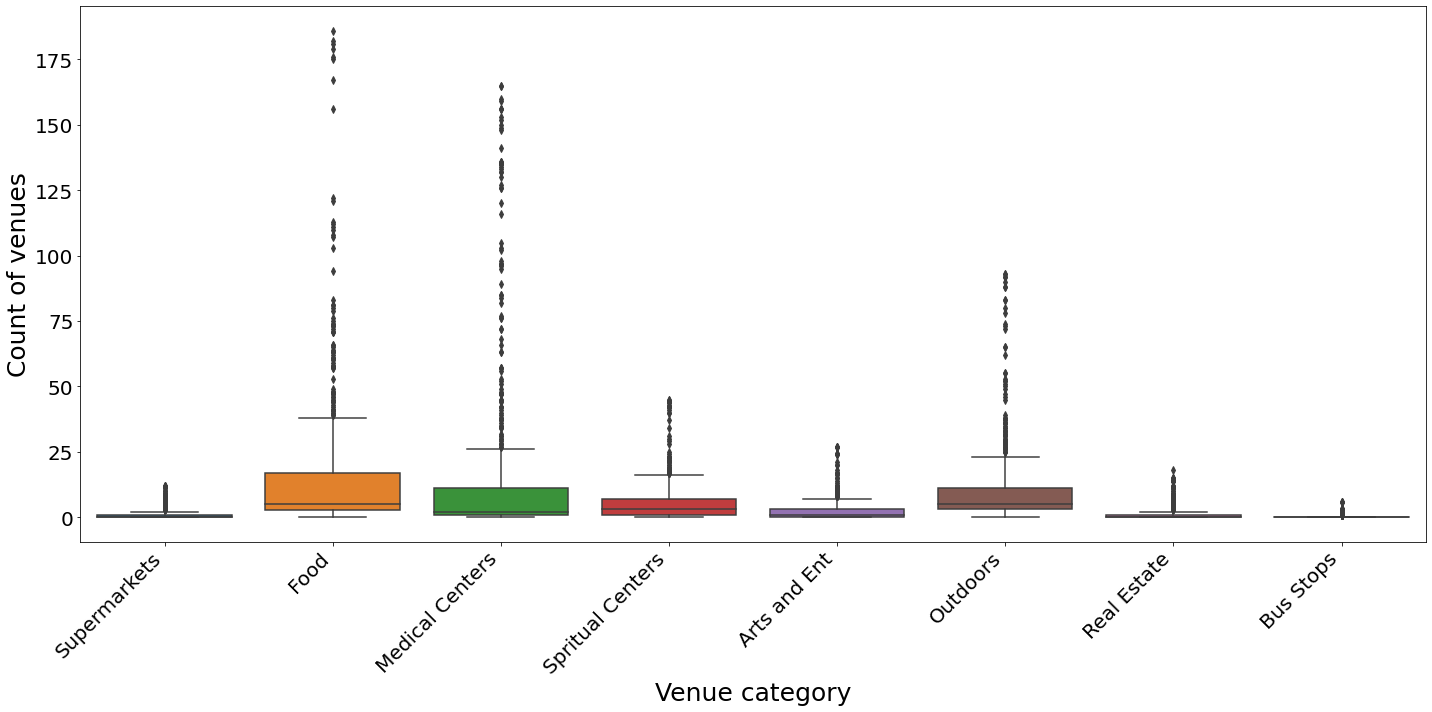

In [21]:

plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = df_wvzip_venues[['Supermarkets', 'Food', 'Medical Centers', 'Spritual Centers', 'Arts and Ent',
                  'Outdoors', 'Real Estate', 'Bus Stops']])
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('boxplots.png')

plt.show()



Zero seems to be a very common outcome.  How many zip codes have zeros for all of these venue types? 

<AxesSubplot:>

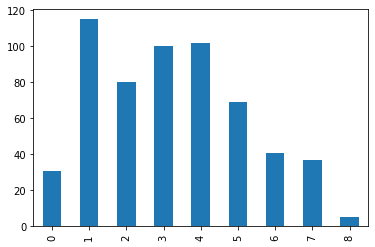

In [19]:
data = df_wvzip_venues[['Supermarkets', 'Food', 'Medical Centers', 'Spritual Centers', 'Arts and Ent',
                  'Outdoors', 'Real Estate', 'Bus Stops']]
Zeroes = (data == 0).astype(int).sum(axis = 1)
Zeroes.value_counts().sort_index()
Zeroes.value_counts().sort_index().plot(kind='bar')


In [17]:
Zeroes.value_counts().sort_index()


0     31
1    115
2     80
3    100
4    102
5     69
6     41
7     37
8      5
dtype: int64

Since there is a great deal of difference in the outcomes, let's create a histogram for each type of venue and the distance variables.


In [9]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
        
    fig.tight_layout()  # Improves appearance a bit.
    
    plt.savefig('histograms.png')
    
    plt.show()


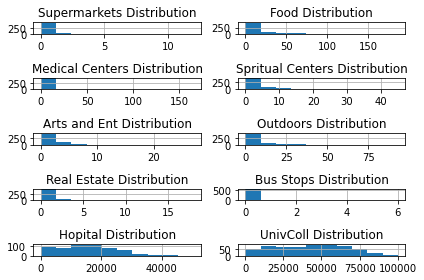

In [10]:
variables = ['Supermarkets', 'Food', 'Medical Centers', 'Spritual Centers', 'Arts and Ent',
            'Outdoors', 'Real Estate', 'Bus Stops', 'Hopital', 'UnivColl']
df = df_wvzip_venues[variables]    

#10 graphs necessary, so 5 rows of 2 graphs will be used.
#n_rows = 5
#n_cols = 2

draw_histograms(df, variables, 5, 2)


In [15]:
def draw_sep_histograms(df, variables):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        
        df[var_name].hist(bins=20)
        plt.title(var_name+" Distribution")
        plt.show()
#    fig.tight_layout()  # Improves appearance a bit.
    
#    plt.savefig('histograms.png')
    
    


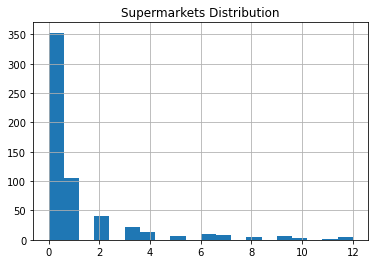

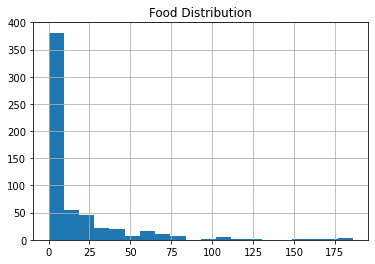

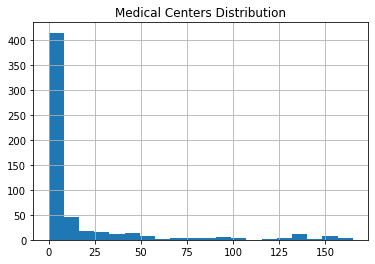

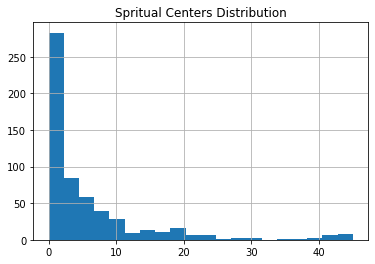

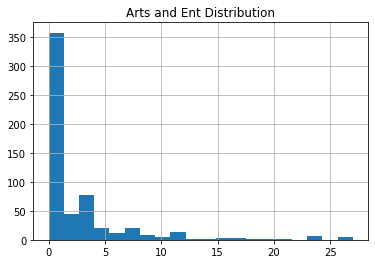

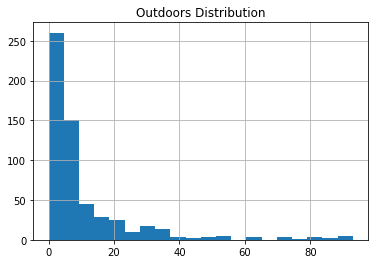

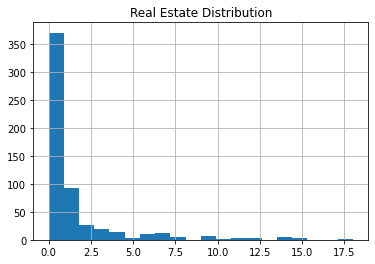

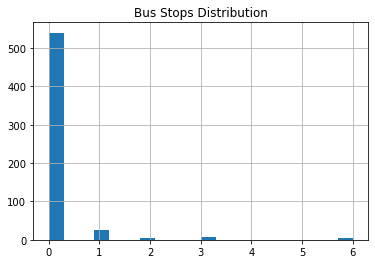

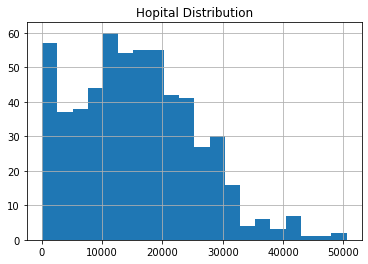

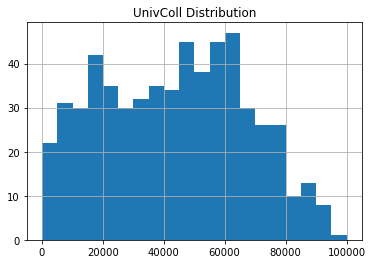

In [16]:
draw_sep_histograms(df, variables)

In [9]:
df.describe()

,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
count,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000
mean,1.120690,16.537931,16.987931,5.817241,2.644828,10.948276,1.312069,0.131034,15806.034483,43569.715517
std,2.192605,28.652590,35.165508,8.670183,4.665094,15.850361,2.828585,0.630324,9787.201536,23593.496377
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,141.000000
25%,0.000000,2.750000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,8643.000000,23786.500000
50%,0.000000,5.000000,2.000000,3.000000,1.000000,5.000000,0.000000,0.000000,15215.000000,44743.500000
75%,1.000000,17.000000,11.250000,7.000000,3.000000,11.000000,1.000000,0.000000,22279.250000,61968.250000
max,12.000000,186.000000,165.000000,45.000000,27.000000,93.000000,18.000000,6.000000,50510.000000,99997.000000


In [17]:
df.corr()

,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
Supermarkets,1.000000,0.918140,0.911019,0.848172,0.779894,0.841087,0.826568,0.522149,-0.533329,-0.315436
Food,0.918140,1.000000,0.877395,0.902605,0.837500,0.903622,0.874501,0.424704,-0.532997,-0.320997
Medical Centers,0.911019,0.877395,1.000000,0.849900,0.769315,0.828933,0.802228,0.492595,-0.521810,-0.295524
Spritual Centers,0.848172,0.902605,0.849900,1.000000,0.785106,0.869763,0.798056,0.467691,-0.543009,-0.303163
Arts and Ent,0.779894,0.837500,0.769315,0.785106,1.000000,0.844303,0.766896,0.546819,-0.500424,-0.190232
Outdoors,0.841087,0.903622,0.828933,0.869763,0.844303,1.000000,0.829362,0.473824,-0.483650,-0.256806
Real Estate,0.826568,0.874501,0.802228,0.798056,0.766896,0.829362,1.000000,0.407127,-0.471813,-0.253535
Bus Stops,0.522149,0.424704,0.492595,0.467691,0.546819,0.473824,0.407127,1.000000,-0.230124,-0.007034
Hopital,-0.533329,-0.532997,-0.521810,-0.543009,-0.500424,-0.483650,-0.471813,-0.230124,1.000000,0.342162
UnivColl,-0.315436,-0.320997,-0.295524,-0.303163,-0.190232,-0.256806,-0.253535,-0.007034,0.342162,1.000000


In [ ]:
plt.hexbin(x, y, gridsize=30, cmap='Blues')
cb = plt.colorbar(label='count in bin')

<a id='item4'></a>


## 4. Cluster Neighborhoods


Import required packages

In [3]:
# Import required packages
#import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [4]:
variables = ['Supermarkets', 'Food', 'Medical Centers', 'Spritual Centers', 'Arts and Ent',
            'Outdoors', 'Real Estate', 'Bus Stops', 'Hopital', 'UnivColl']
df = df_wvzip_venues[variables]  

First, the data needs to be standardized to a mean of zero and standard deviation of one before using 
_k_-means.  This assures that the absolute value of the variable will not cause it to have more weight in 
determining clusters since _k_-means uses Euclidean distance.

In [5]:
scaler = StandardScaler()
# transform data
scaled_df = scaler.fit_transform(df)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


For _k_-means, we will need to decide on the number of clusters to use and the vary the starting centroids to use for each group.


In [14]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_df)
    Sum_of_squared_distances.append(km.inertia_)

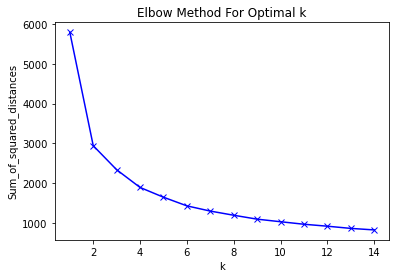

In [15]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [6]:
Sum_of_squared_distances = []
K = range(3,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_df)
    Sum_of_squared_distances.append(km.inertia_)

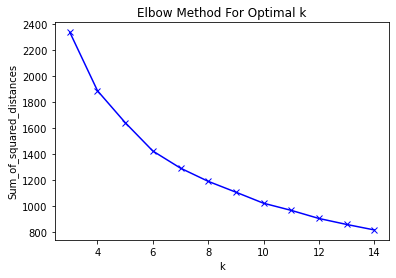

In [9]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Note that there are _elbows_ at k = 2 and k = 4 in the first graph.  When we zoom in using the second graph, we see elbows at k = 4 and k = 6  We will use k = 4 to form our clusters the first time.

In [23]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scaled_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 0, 3, 3, 3, 1, 0, 3, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [24]:
#df_wvzip_venues[["Cluster Labels"]] = kmeans.labels_               Use if repeating.

In [25]:
# add clustering labels
df_wvzip_venues.insert(0, 'Cluster Labels', kmeans.labels_)

df_wvzip_venues.head() # check the last columns!

Finally, let's visualize the resulting clusters


In [12]:
lat_lng_coords = None
    # loop until you get the coordinates
while(lat_lng_coords is None):
    g = geocoder.arcgis('WV')
    lat_lng_coords = g.latlng

Latitude=lat_lng_coords[0]
Longitude=lat_lng_coords[1]

print('The geograpical coordinate of West Virginia are {}, {}.'.format(Latitude, Longitude))

The geograpical coordinate of West Virginia are 38.64241493700007, -80.61361664099996.


In [26]:
# create map
map_wv_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_wvzip_venues['latitude'], df_wvzip_venues['longitude'], df_wvzip_venues['zipcode'], df_wvzip_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_wv_clusters)

sw = df_wvzip_venues[['latitude', 'longitude']].min().values.tolist()
ne = df_wvzip_venues[['latitude', 'longitude']].max().values.tolist()

map_wv_clusters.fit_bounds([sw, ne]) 

# where m is my map object. And 5 is the time (seconds) to render the map
import io
from PIL import Image

#img_data = map_wv._to_png(5)
#img = Image.open(io.BytesIO(img_data))
#img.save('ZIPmap.png')
       
map_wv_clusters

<a id='item5'></a>


## 5. Examine Clusters


Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster. 


#### Cluster 1


In [29]:
df_wvzip_venues.loc[df_wvzip_venues['Cluster Labels'] == 0,df_wvzip_venues.columns[list(range(9, df_wvzip_venues.shape[1]))]].describe()

,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.141129,3.625000,1.850806,1.661290,0.637097,4.641129,0.185484,0.012097,23691.971774,60124.354839
std,0.371344,3.868342,3.529792,2.410796,1.222824,4.738959,0.560031,0.109539,8039.585298,15990.381749
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,479.000000,24688.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18562.250000,48583.500000
50%,0.000000,3.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000,23757.500000,60219.500000
75%,0.000000,5.000000,2.000000,2.000000,1.000000,6.000000,0.000000,0.000000,28244.750000,72266.250000
max,2.000000,24.000000,38.000000,19.000000,10.000000,31.000000,4.000000,1.000000,50510.000000,94705.000000


#### Cluster 2


In [27]:
df_wvzip_venues.loc[df_wvzip_venues['Cluster Labels'] == 3,df_wvzip_venues.columns[list(range(9, df_wvzip_venues.shape[1]))]].describe()

,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,0.747126,11.739464,9.065134,4.827586,2.206897,8.068966,0.720307,0.057471,11586.636015,31163.609195
std,0.951336,10.634900,12.284746,4.154350,2.776846,7.091913,1.203492,0.362353,5750.319625,17312.505496
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,320.000000,861.000000
25%,0.000000,3.000000,1.000000,2.000000,0.000000,4.000000,0.000000,0.000000,8186.000000,17604.000000
50%,0.000000,7.000000,5.000000,4.000000,1.000000,6.000000,0.000000,0.000000,11634.000000,27060.000000
75%,1.000000,19.000000,12.000000,7.000000,4.000000,10.000000,1.000000,0.000000,15868.000000,42971.000000
max,4.000000,45.000000,77.000000,19.000000,16.000000,39.000000,7.000000,3.000000,24453.000000,80079.000000


#### Cluster 3


In [28]:
df_wvzip_venues.loc[df_wvzip_venues['Cluster Labels'] == 1,df_wvzip_venues.columns[list(range(9, df_wvzip_venues.shape[1]))]].describe()

,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,4.931034,64.637931,89.982759,19.913793,8.362069,34.241379,6.241379,0.431034,4181.155172,33150.931034
std,2.183367,20.825674,40.460720,8.698224,4.478793,13.981580,3.315621,0.818901,2835.180354,29056.526668
min,1.000000,38.000000,32.000000,5.000000,1.000000,15.000000,1.000000,0.000000,90.000000,141.000000
25%,3.250000,47.250000,52.250000,15.000000,4.250000,22.250000,4.000000,0.000000,1598.000000,8090.250000
50%,5.000000,61.500000,85.000000,18.500000,8.000000,31.500000,6.000000,0.000000,4528.000000,17618.500000
75%,6.750000,73.750000,131.500000,23.000000,11.750000,43.250000,8.000000,1.000000,6237.000000,63839.500000
max,9.000000,122.000000,156.000000,42.000000,20.000000,72.000000,18.000000,3.000000,14163.000000,88170.000000


#### Cluster 4


In [29]:
df_wvzip_venues.loc[df_wvzip_venues['Cluster Labels'] == 2,df_wvzip_venues.columns[list(range(9, df_wvzip_venues.shape[1]))]].describe()

,Supermarkets,Food,Medical Centers,Spritual Centers,Arts and Ent,Outdoors,Real Estate,Bus Stops,Hopital,UnivColl
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,10.307692,144.615385,139.153846,42.076923,24.230769,85.153846,12.692308,2.538462,1944.000000,23318.384615
std,1.548366,43.509651,18.497055,3.328201,2.586949,7.162939,2.097006,2.401922,1743.658415,33328.978934
min,7.000000,60.000000,105.000000,34.000000,18.000000,73.000000,9.000000,1.000000,382.000000,2356.000000
25%,9.000000,110.000000,134.000000,41.000000,24.000000,80.000000,11.000000,1.000000,1010.000000,4048.000000
50%,10.000000,167.000000,136.000000,44.000000,24.000000,88.000000,14.000000,1.000000,1281.000000,8371.000000
75%,12.000000,179.000000,159.000000,44.000000,27.000000,92.000000,14.000000,6.000000,2055.000000,18006.000000
max,12.000000,186.000000,165.000000,45.000000,27.000000,93.000000,15.000000,6.000000,6513.000000,99997.000000


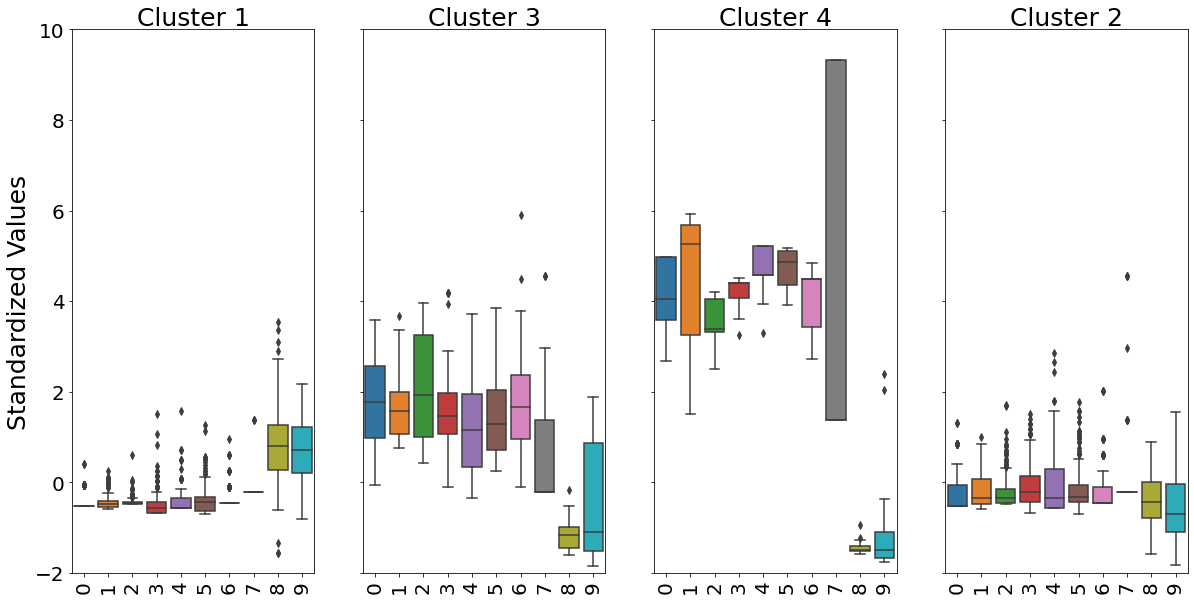

In [30]:

import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Standardized Values', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

lst = [0, 3, 1, 2] 
i = 0
 
for k in lst:
    #Set same y axis limits
    i = i+1
    axes[k].set_ylim(-2,10)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(i), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = scaled_df[df_wvzip_venues['Cluster Labels'] == k], ax=axes[k])

plt.show()



## 

## Summary and discussion contained in the project paper and PowerPoint.